---
Material for the course "Introducción a la inteligencia artificial"

The following notes written by SERGIO G RODRIGO (2023-2024)</font>

---
# **Classifying Digits with Tensorflow Keras**


# Mount Google Drive




In [ ]:
#Your google drive is made accesible to Colab.
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    # The working directory
    %cd '/content/drive/MyDrive/your_path/'
    %ls -lht
    # To import own packages set local path in packages syspath
    import sys
    sys.path.insert(0,"./")
except ImportError:
    print("You are not in google.colab!!")
    pass

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/CURSO_AI_22_23/material_redes_neuronales
total 25M
-rw------- 1 root root 1.4M Apr 11 14:47  tensorflow_keras_ai_course_22-23.ipynb
-rw------- 1 root root 5.7M Dec 27 12:49 'Curso_AI_Tema5_Redes neuronales - Tensorflow-Keras 22-23.pdf'
-rw------- 1 root root 106K Dec 12 19:38  model_saved_pinn.h5
-rw------- 1 root root 2.1K Nov 26 22:57  my_history.npy
-rw------- 1 root root  39K Nov 22 12:13  lamina_dielectrica_delgada.png
-rw------- 1 root root 6.2M Nov 21 11:47  model_concatenated.h5
-rw------- 1 root root 780K Nov 21 11:47  model_conv2d.h5
-rw------- 1 root root 102K Nov 21 11:47  model_summary.png
-rw------- 1 root root 187K Nov 21 11:47  epochs_evolution.png
-rw------- 1 root root  661 Nov 21 11:47  loss_mse_.dat
drwx------ 2 root root 4.0K Nov 21 11:09  DATABASE/
-rw------- 1 root root 219K Nov 15 12:24  model_dense_improved_re

# Auxiliary functions

In [58]:
%matplotlib inline
import numpy as np
import random

# Two functions for digits visualization
def show_one_digit(digit, npixelsx):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(digit.reshape([npixelsx, npixelsx]))
    plt.show()

def show_n_m_digits(n, m, digits, labels, npixels_x):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(n*2, m*2))
    columns = n
    rows = m
    ax = []
    for i in range(columns*rows):
        img = digits[i,:].reshape([npixels_x,npixels_x])
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("label:"+str(labels[i]))  # set title
        plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
        plt.imshow(img)
    plt.show()

# An alternative to GraphData() function
def plot_score(pathresults,history_keras,loss_name,metrics_name):
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    history_dict=history_keras.history
    training_cost=history_dict[loss_name]
    training_accuracy=history_dict[metrics_name]
    evaluation_cost=history_dict['val_'+loss_name]
    evaluation_accuracy=history_dict['val_'+metrics_name]

    epochs=len(evaluation_cost)
    print("Número de épocas: %d\n" % (epochs))
    xx = np.linspace(0,epochs-1,epochs)
    # in a file
    filemse="/loss_mse_.dat"
    file=os.path.exists(pathresults+filemse)
    if (file):
        os.remove(pathresults+filemse)
        print(pathresults+filemse+" removed")
    with open(pathresults+filemse, 'w') as f1:
       for i in range(0,epochs):
           summary= str(xx[i])+' '+str(evaluation_cost[i])+' '+str(evaluation_accuracy[i])+' '+str(training_cost[i])+' '+str(training_accuracy[i])+''+'\n'
           f1.write(summary)
    f1.close()

    # as a figure
    # Four axis
    fig2, ax2 = plt.subplots(2,2, figsize=(10,10)) #sharex='col', sharey='row',
    ax2[0,0].plot(xx,evaluation_cost, color="red", label="Loss (validation)")
    ax2[0,1].plot(xx,evaluation_accuracy, color="blue", label="Metrics (validation)")
    ax2[1,0].plot(xx,training_cost, color="orange", label="Loss (training)")
    ax2[1,1].plot(xx,training_accuracy, color="cyan", label="Metrics (training)")
    txt = "Epochs"
    ax2[0,0].set_xlabel(txt)
    ax2[0,0].legend()
    ax2[0,1].set_xlabel(txt)
    ax2[0,1].legend()
    ax2[1,0].set_xlabel(txt)
    ax2[1,0].legend()
    ax2[1,1].set_xlabel(txt)
    ax2[1,1].legend()
    fig2.savefig(pathresults+"/epochs_evolution.png", dpi=200, facecolor="#f1f1f1")

# Load training and validation datasets (MINST)

In [35]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_val, y_val) = mnist.load_data()

output_neurons=10 # Output in the range of [0,9]

n_train=50000   # <= 50000
n_val=10000    # <= 10000

# A subset of training/test data
x_train= x_train[0:n_train]
y_train=y_train[0:n_train]
x_val= x_val[0:n_val]
y_val=y_val[0:n_val]
'''
Nielsen x.shape = (784,1)
Keras x.shape =(784,)
'''
x_train_len=len(x_train)
x_val_len=len(x_val)
print("(train _len,test len)=",x_train_len,x_val_len)
x_train = x_train.reshape(x_train_len, 784)
x_val = x_val.reshape(x_val_len, 784)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

(train _len,test len)= 50000 10000


## A look at the data structure

In [36]:
x=x_train
y=y_train
print('number of images', x.shape[0])
print('number of pixels', x.shape[1])
print('different labels', np.unique(y))
print('number of instances of each pixel', [np.count_nonzero(y == i) for i in np.unique(y)])

number of images 50000
number of pixels 784
different labels [0 1 2 3 4 5 6 7 8 9]
number of instances of each pixel [4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988]


## Shuffle the data

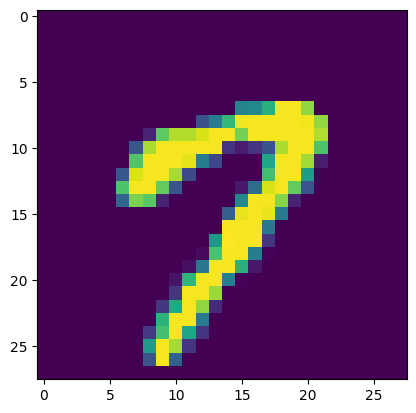

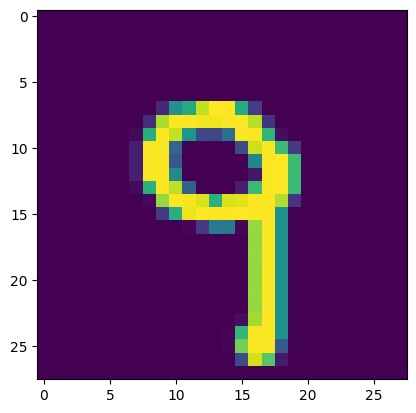

In [37]:
# shuffle the data
nimagenes=x_train.shape[0]
npixelsx=28
npixelsy=28

# Show two examples (before randomize)
show_one_digit(x_train[15,:], npixelsx)

# Shuffle training dataset
shuffle_list = np.random.permutation(range(nimagenes))
x_train = x_train[shuffle_list, :]
y_train = y_train[shuffle_list]

# Show two examples (after randomize)
show_one_digit(x_train[15,:], npixelsx)

## One hot enconding

In [38]:
# convert class vectors to binary class matrices (one hot encoding)
y1h_train = tf.keras.utils.to_categorical(y_train, output_neurons)
y1h_val = tf.keras.utils.to_categorical(y_val, output_neurons)

In [39]:
print(y_train[0:10])
print(y1h_train[0:10])

[9 3 1 4 0 5 4 1 3 0]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Exploring the data

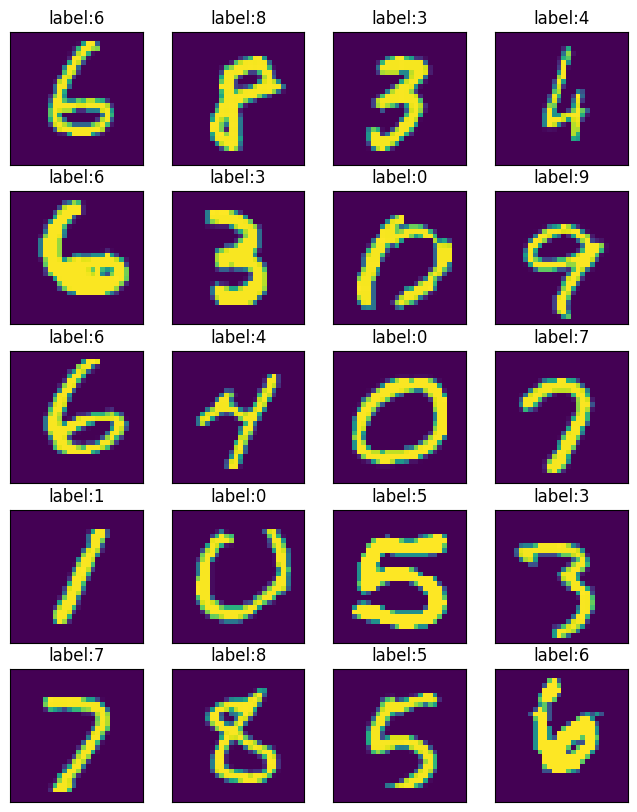

In [40]:
n = 4; m = 5
show_n_m_digits(n, m, x_train[20:40,:], y_train[20:40], npixelsx)

# **Classifying Digits with Tensorflow Keras: dense layers**


In [42]:
# To run the Tensorflow Keras models set to True
run_tf_keras=True

50000 train samples
10000 test samples
x_train shape (50000, 784)
y1h_train shape (50000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5000/5000 [==============================] - 29s 5ms/step - loss: 0.3911 - accuracy: 0.8806 - val_loss: 0.2773 - val_accuracy: 0.9168
Epoch 2/10
5000/5000 [==============================] - 18s 4ms/step - loss: 0.2832 - accuracy: 0.9159 - val_loss: 0.2572 - val_accuracy: 0.9216
Epoch 3/10
5000/5000 [==============================] - 24s 5ms/

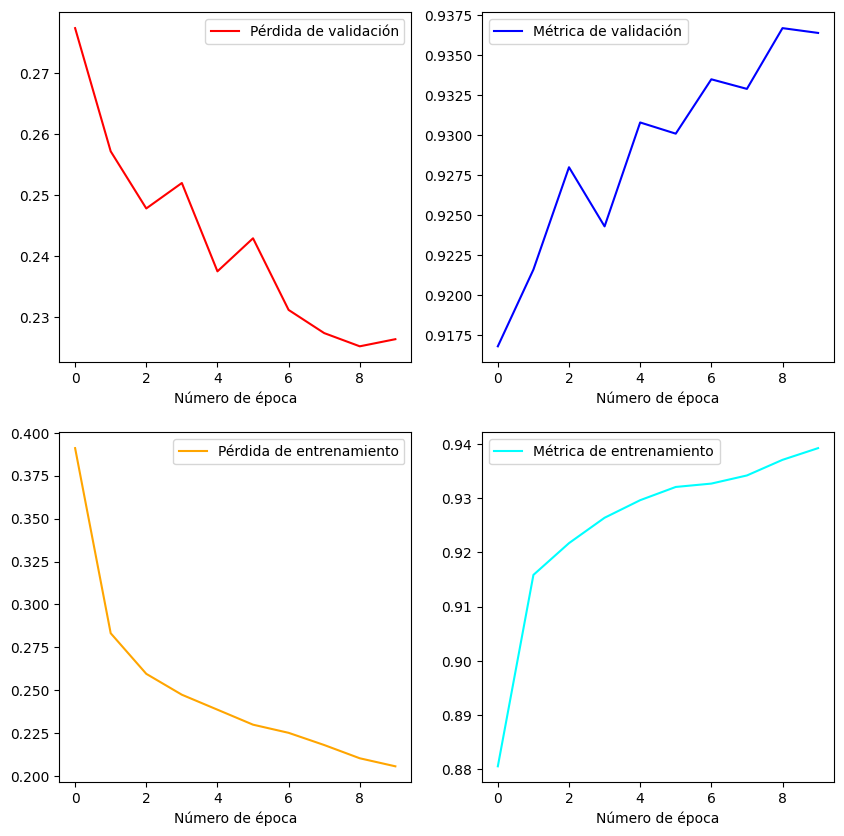

In [43]:
# Tensorflow Keras packages
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

# Check data and labels previously defined
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y1h_train shape",y1h_train.shape)

# Input and output neurons (from the data)
input_neurons  = x_train.shape[1]
output_neurons = y1h_train.shape[1]

# Hiperparameters
batch_size = 10
epochs = 10
eta = 1.0
hidden_layer_neurons=15

# Define the model
model = Sequential()
model.add(Input(shape=(input_neurons,)))
model.add(Dense(hidden_layer_neurons, activation='sigmoid'))
model.add(Dense(output_neurons, activation='sigmoid'))
model.summary()

optimizer=SGD(learning_rate=eta)

model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

if(run_tf_keras):
    history = model.fit(x_train, y1h_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y1h_val))
   # Guardar el modelo
    models.save_model(model,'./model_dense_simple.h5',save_format='h5')
   # history from training
    print("Keys:",history.history.keys())
    plot_keys=list(history.history.keys())
    plot_score("./",history,loss_name=plot_keys[0],metrics_name=plot_keys[1])


## **Plotting the results: model summary, score and performance** <a name="Plots"></a>

In [44]:
#model=models.load_model("./model_dense_simple.h5")
model.summary()

score = model.evaluate(x_val, y1h_val, verbose=0)
print("World record: 99.79%")
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________
World record: 99.79%
Test loss: 0.2264440655708313
Test accuracy: 0.9363999962806702


## How wierd are those digits the model did not catch?

### A few auxiliary functions

In [45]:
def inverse_one_hot_enconding(y_enconded):
     y = np.argmax(y_enconded,axis=1)
     return y

def fail_to_predict(model,model_name,x,y):
    y_pred=model.predict(x)
    y_pred_num=inverse_one_hot_enconding(y_pred)
    y_num=inverse_one_hot_enconding(y)
    dif=list(y_pred_num-y_num)
    fail_to_predict_index=[indx for indx,val in enumerate(dif) if val!=0]
    accu=(len(y)-len(fail_to_predict_index))/len(y)
    print("Model %s FAILED to predict %.f labels out of %.f. Accuracy= %.4f \n" %(model_name,len(fail_to_predict_index),len(y),accu))
    return fail_to_predict_index

def show_wierd_digits(model_filename,x,y,no_digits,npixelsx,verbose=0):
    model=models.load_model(model_filename+'.h5')
    fail_to_predict_index=fail_to_predict(model,model_filename,x,y)
    n=no_digits
    x_fail=x[fail_to_predict_index[0:n**2]]
    y_fail=y[fail_to_predict_index[0:n**2]]
    y_fail=inverse_one_hot_enconding(y_fail)
    y_fail=np.reshape(y_fail,(y_fail.shape[0],1))
    if(verbose==1):
      model.summary()
      show_n_m_digits(n,n, x_fail, y_fail,npixelsx)
    return  model,fail_to_predict_index

### Check performance

313/313 [==============================] - 1s 2ms/step
Model model_dense_simple FAILED to predict 636 labels out of 10000. Accuracy= 0.9364 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


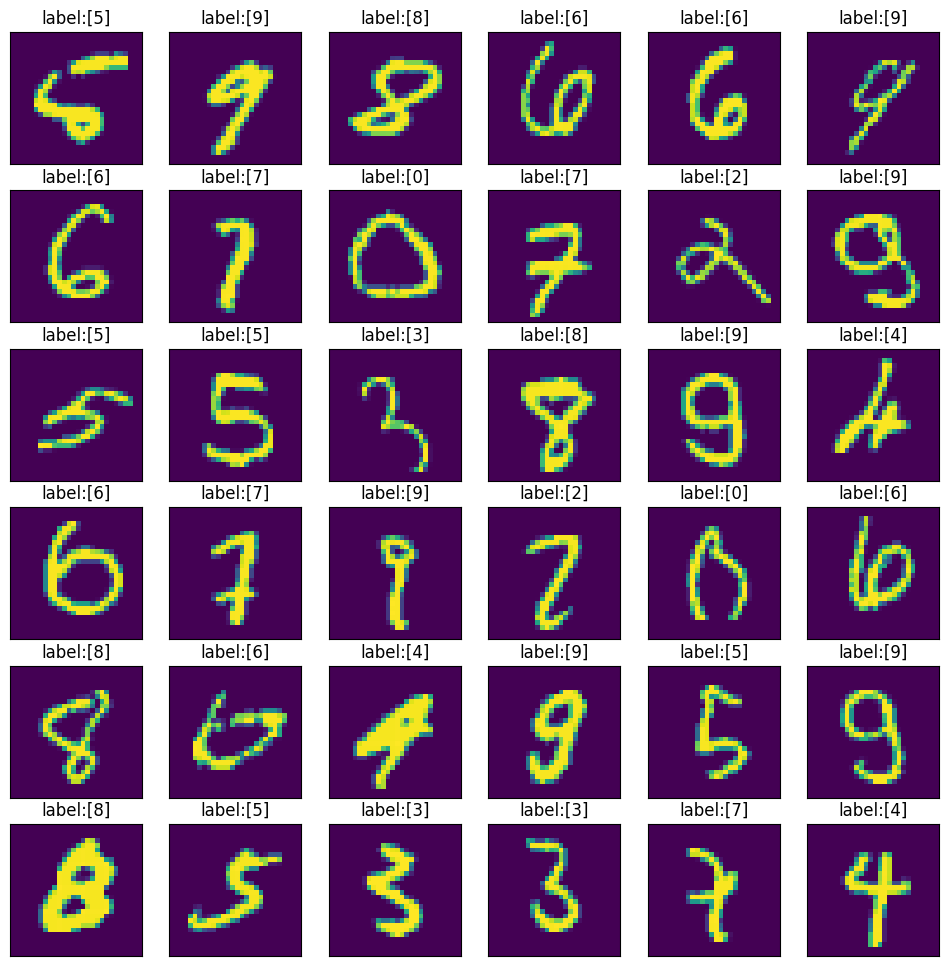

simple failed digits  636


In [46]:
# We load the simple keras model and create a list with digits
# unable to predict by the model
model_dense_simple,fail_to_predict_index_simple=show_wierd_digits('model_dense_simple',x_val,y1h_val,6,npixelsx,verbose=1)
simple=set(fail_to_predict_index_simple)
print("simple failed digits ",len(simple))

#**Going beyond the Sequential model: an introduction to Keras functional application programming interface (API)**

## A simple Keras model based on dense layers using the Keras API

In [47]:
# Tensorflow Keras packages
from tensorflow.keras import models,layers,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

# Check data and labels previously defined
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y1h_train shape",y1h_train.shape)

# Input and output neurons (from the data)
input_neurons  = x_train.shape[1]
output_neurons = y1h_train.shape[1]

# Hiperparameters
batch_size = 10
epochs = 10
eta = 1.0
hidden_layer_neurons=15

# Define the model
seq=False
if(seq==True):
  model = Sequential()
  model.add(Input(shape=(input_neurons,)))
  model.add(Dense(hidden_layer_neurons, activation='sigmoid'))
  model.add(Dense(output_neurons, activation='sigmoid'))
else:
  input_tensor=Input(shape=(input_neurons,),name='input')
  hidden_tensor = layers.Dense(hidden_layer_neurons, activation='sigmoid',name='hidden')(input_tensor)
  output_tensor = layers.Dense(output_neurons,activation='sigmoid',name='output')(hidden_tensor)
  model = Model(input_tensor,output_tensor)

model.summary()

optimizer=SGD(learning_rate=eta)

model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

run_tf_keras=True
if(run_tf_keras):
    history = model.fit(x_train, y1h_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y1h_val))

    models.save_model(model,'./model_dense_simple.h5',save_format='h5')

50000 train samples
10000 test samples
x_train shape (50000, 784)
y1h_train shape (50000, 10)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 hidden (Dense)              (None, 15)                11775     
                                                                 
 output (Dense)              (None, 10)                160       
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
5000/5000 [==============================] - 20s 4ms/step - loss: 1.2972 - accuracy: 0.7075 - val_loss: 0.7428 - val_accuracy: 0.8440
Epoch 2/10
5000/5000 [==============================] - 16s 3ms/step - loss: 0.6075 - accuracy: 0.8613 - val_loss: 0.4845 - val_accuracy: 0.8909
Epoch 3/10
5000/5000 [==============================] - 23s 5ms/step - loss: 0.4533 - accuracy: 0.8877 - val_loss: 0.3957 - val_accuracy: 0.9039
Epoch 4/10
5000/5000 [==============================] - 18s 4ms/step - loss: 0.3885 - accuracy: 0.8989 - val_loss: 0.3517 - val_accuracy: 0.9092
Epoch 5/10
5000/5000 [==============================] - 18s 4ms/step - loss: 0.3523 - accuracy: 0.9055 - val_loss: 0.3249 - val_accuracy: 0.9136
Epoch 6/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.3286 - accuracy: 0.9101 - val_loss: 0.3081 - val_accuracy: 0.9181
Epoch 7/10
5000/5000 [==============================] - 18s 4ms/step - loss: 0.3112 - accuracy: 0.9142 - val_loss: 0.2958 - val_ac

### **Using the Keras functional API**

In [51]:
from tensorflow.keras import models
model=models.load_model("./model_dense_simple.h5")
model.summary()

score = model.evaluate(x_val, y1h_val, verbose=0)
print("World record: 99.79%")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Let's use Keras functional API: a feed_forward function
def feed_forward(x):
  prediction = []
  for xi in x:
    # Each digit, xi, must be reshaped
    a=np.reshape(xi,(1,xi.shape[0]))
    # For each layer in model we use the layer properties to
    # feedforward
    for layer in model.layers[1:]:
       print("Layer %s" %(layer.name))
       w=layer.kernel
       b=layer.bias
       print(a.shape,w.shape,b.shape) #
       z=a@w+b
       a=layer.activation(z)
    prediction.append(a)
  return prediction

# feed_forward in pythonic style
def feed_forward_pythonic(x):
  a=np.reshape(x,(x.shape[0],1,x.shape[1]))
  for layer in model.layers[1:]:
      w,b=layer.kernel,layer.bias
      a=layer.activation(a@w+b)
  return a

# Test few digits
model_out_naive=feed_forward(x_val[0:40])
model_out_naive2=feed_forward_pythonic(x_val[0:40])
model_out = model.predict(x_val[0:40])

naive_predictions = [np.argmax(i) for i in model_out_naive]
naive_predictions2 = [np.argmax(i) for i in model_out_naive2]
predictions =       [np.argmax(i) for i in model_out]

print("\nnaive predictions:",naive_predictions)
print("naive predictions:",naive_predictions2)
print("actual predictions:",predictions)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 hidden (Dense)              (None, 15)                11775     
                                                                 
 output (Dense)              (None, 10)                160       
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________
World record: 99.79%
Test loss: 0.2702982723712921
Test accuracy: 0.9246000051498413
Layer hidden
(1, 784) (784, 15) (15,)
Layer output
(1, 15) (15, 10) (10,)
Layer hidden
(1, 784) (784, 15) (15,)
Layer output
(1, 15) (15, 10) (10,)
Layer hidden
(1, 784) (784, 15) (15,)
Layer output
(1, 15) (15, 10) (10,)
Layer hidden
(

# **Classifying Digits with Tensorflow Keras: convolutional networks**

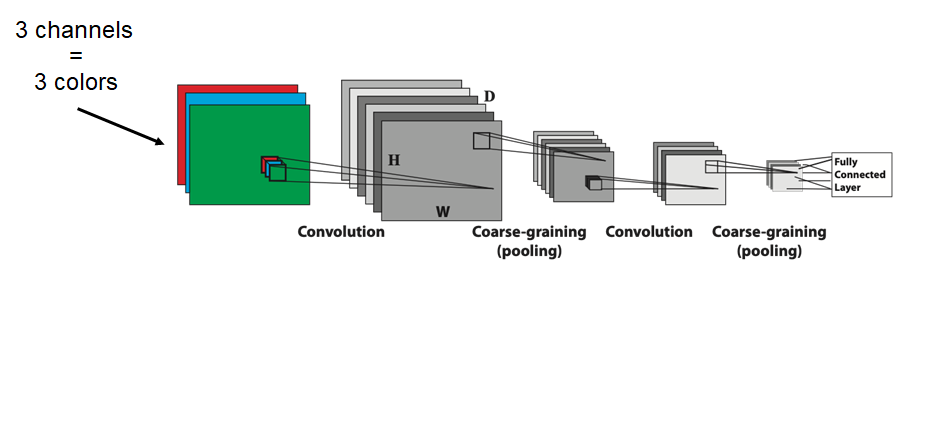

### Adapt data to CONV2D



In [52]:
# Previous shapes of {data,labels}
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("old x_train shape",x_train.shape)
print("old y1h_train shape",y1h_train.shape)

# From digits-like rows to digits
input_channels=1
def x_from_dense_to_conv2d(x,pixels,input_channels):
     return x.reshape((len(x),pixels,pixels,input_channels))

x_train_conv2d=x_from_dense_to_conv2d(x_train,npixelsx,1)
x_val_conv2d=x_from_dense_to_conv2d(x_val,npixelsx,1)

# New shapes of {data,labels}
print("\n new conv2D x_train shape",x_train_conv2d.shape)
print("y1h_train shape doesn't change")

img_cols=x_train_conv2d.shape[1]
img_rows=x_train_conv2d.shape[2]
input_shape = (img_cols,img_rows,input_channels)

50000 train samples
10000 test samples
old x_train shape (50000, 784)
old y1h_train shape (50000, 10)

 new conv2D x_train shape (50000, 28, 28, 1)
y1h_train shape doesn't change


### Run a convnet based on Tensorflow Keras

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

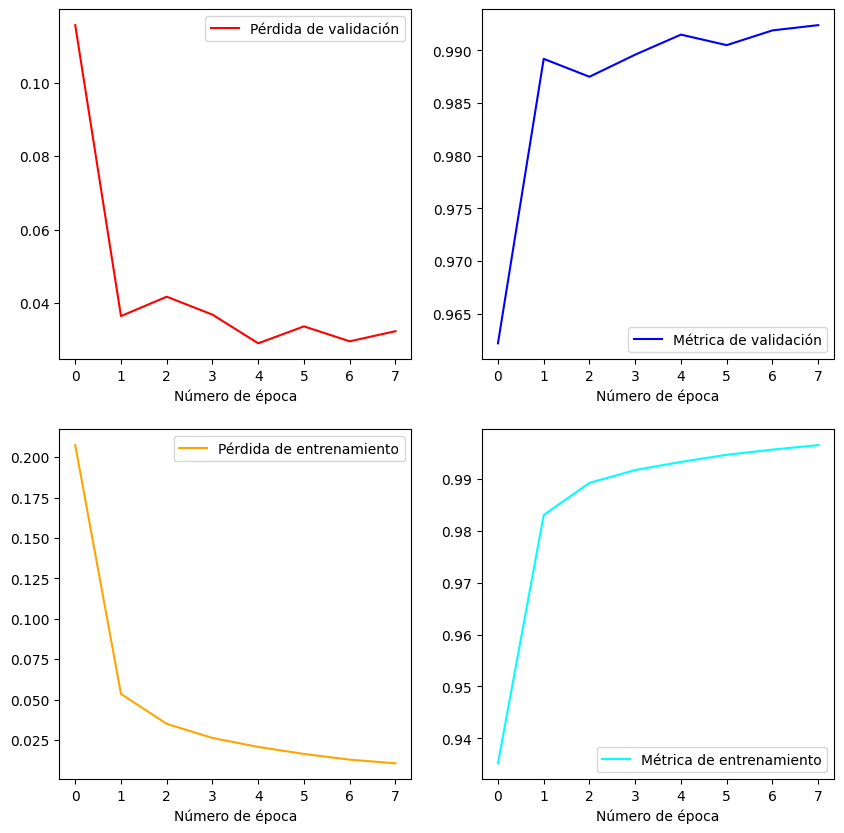

In [54]:
'''
Adapted from Chollet's book "Deep learning with Python"
'''
# Tensorflow Keras packages
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# To run the Tensorflow Keras models set to True
run_tf_keras=True

# Hiperparameters
batch_size = 64
epochs=8

# Define the model
model = Sequential()

# ----->>> CONV2D
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',\
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
# <<<----- CONV2D

# ----->>> densily connected classifier
model.add(Dense(64, activation='relu')) # new dense layer added
model.add(Dense(output_neurons, activation='softmax'))
# <<<----- densily connected classifier

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

if(run_tf_keras):
    history=model.fit(x_train_conv2d,y1h_train,epochs=epochs,batch_size=batch_size,\
                      verbose=1,validation_data=(x_val_conv2d, y1h_val))

    models.save_model(model,'./model_conv2d.h5',save_format='h5')
    # history from training
    print("Keys:",history.history.keys())
    plot_keys=list(history.history.keys())
    plot_score("./",history,loss_name=plot_keys[0],metrics_name=plot_keys[1])

### Plotting the results: model summary, score and performance

In [57]:
from tensorflow.keras import models

model=models.load_model("./model_conv2d.h5")
model.summary()

score = model.evaluate(x_val_conv2d, y1h_val, verbose=0)
print("World record: 99.79%")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              